In [8]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import pyplot as plt

# override all pandas display limits
pd.options.display.max_columns = None
pd.options.display.max_rows = None


In [9]:
# load parquet files
data_path = Path("../../data")
notebooks_path = Path(os.getcwd())
data_dir = {}

for file_path in list((notebooks_path / data_path).glob("*.parquet")):
    # retrieve the name of the file without the extension for all OS
    data = pd.read_parquet(file_path)
    # if "Time" in df.columns:
    #     df["Time"] = pd.to_datetime(df["Time"])
    data_dir[str(file_path).replace("\\", "/").split("/")[-1].split(".")[0]] = df


ID_vars = ["PatientID", "Time", "RecordID"]
# stationary variables
stationary_vars = ["Age", "Gender", "Height", "ICUType"]
# dynamic variables
dynamic_vars = data_dir["set-a"].columns.difference(stationary_vars + ID_vars).tolist()
# # key_translator for data dict
# translate_key_inv = {"set-a": "train", "set-b": "valid", "set-c": "test", 
#                  "Outcomes-a": "train_label", "Outcomes-b": "valid_label", "Outcomes-c": "test_label"}
# # invert translate_key
# translate_key = {v: k for k, v in translate_key_inv.items()}
print("ID_vars:", ID_vars)
print("stationary_vars:", stationary_vars)
print("dynamic_vars:", dynamic_vars)



ID_vars: ['PatientID', 'Time', 'RecordID']
stationary_vars: ['Age', 'Gender', 'Height', 'ICUType']
dynamic_vars: ['ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Bilirubin', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'K', 'Lactate', 'MAP', 'MechVent', 'Mg', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Platelets', 'RespRate', 'SaO2', 'SysABP', 'Temp', 'TroponinI', 'TroponinT', 'Urine', 'WBC', 'Weight', 'pH', None]


## Simple EDA

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196000 entries, 0 to 195999
Data columns (total 45 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time         196000 non-null  int64  
 1   BUN          5993 non-null    float64
 2   Creatinine   5996 non-null    float64
 3   DiasABP      10282 non-null   float64
 4   GCS          4505 non-null    float64
 5   Glucose      5567 non-null    float64
 6   HCO3         5949 non-null    float64
 7   HCT          8053 non-null    float64
 8   HR           15020 non-null   float64
 9   K            5982 non-null    float64
 10  Lactate      4420 non-null    float64
 11  MAP          10214 non-null   float64
 12  Mg           6080 non-null    float64
 13  Na           5851 non-null    float64
 14  PaCO2        11549 non-null   float64
 15  PaO2         11500 non-null   float64
 16  Platelets    6788 non-null    float64
 17  RecordID     196000 non-null  float64
 18  RespRate     3384 non-nu

In [11]:
data.describe()

Parameter,Time,BUN,Creatinine,DiasABP,GCS,Glucose,HCO3,HCT,HR,K,Lactate,MAP,Mg,Na,PaCO2,PaO2,Platelets,RecordID,RespRate,SysABP,Temp,Urine,WBC,Weight,pH,Age,Gender,Height,ICUType,PatientID,FiO2,MechVent,NIDiasABP,NIMAP,NISysABP,SaO2,None,Albumin,ALP,ALT,AST,Bilirubin,Cholesterol,TroponinT,TroponinI
count,196000.000000,5993.000000,5996.000000,10282.000000,4505.000000,5567.000000,5949.000000,8053.000000,15020.000000,5982.000000,4420.00000,10214.000000,6080.000000,5851.000000,11549.000000,11500.000000,6788.000000,196000.00000,3384.000000,10282.000000,8220.000000,4603.000000,6103.000000,196000.000000,11802.000000,196000.00000,196000.000000,196000.000000,196000.000000,196000.00000,5780.000000,5694.0,8014.000000,7919.000000,8014.000000,3936.000000,1285.000000,1455.000000,1759.000000,1759.000000,1759.000000,1805.000000,308.000000,1025.000000,227.000000
mean,24.000000,25.791173,1.412925,59.642482,11.868147,144.881175,22.750378,30.886160,89.722636,4.137688,2.95129,79.453153,1.993183,139.032644,40.911118,159.984696,197.972304,157888.86750,19.985963,118.612332,36.863637,171.351836,13.703488,74.137926,7.371191,64.72850,0.556000,88.240775,2.767500,157888.86750,0.563438,1.0,58.318630,77.644365,118.683679,96.630335,2.914747,2.975430,98.007675,127.735077,212.612848,2.506787,148.529221,1.647229,2.226432
std,14.142172,21.362174,1.242846,14.533010,3.977256,65.176077,4.775961,4.982097,20.317828,0.631359,2.17859,17.088812,0.395135,4.897559,9.435118,90.977476,96.635507,2947.82944,6.273229,25.493955,1.147541,216.327219,12.455857,31.919909,0.075746,16.81451,0.498864,85.835022,1.026377,2947.82944,0.195272,0.0,18.201909,18.321326,28.419604,3.889191,0.694754,0.669212,57.144690,368.805200,798.104161,5.925489,31.093362,4.522670,2.978285
min,0.000000,3.000000,0.300000,-1.000000,3.000000,25.000000,6.000000,16.200000,12.000000,2.600000,0.70000,0.000000,1.100000,116.000000,20.000000,36.000000,15.000000,152871.00000,0.000000,0.000000,0.000000,0.000000,1.900000,-1.000000,7.050000,16.00000,-1.000000,-1.000000,1.000000,152871.00000,0.250000,1.0,-1.000000,38.000000,0.000000,63.000000,1.500000,1.500000,21.000000,7.000000,11.000000,0.100000,80.000000,0.010000,0.300000
25%,12.000000,12.000000,0.700000,52.000000,10.000000,102.000000,20.000000,27.500000,76.000000,3.700000,1.60000,69.000000,1.700000,137.000000,35.000000,94.000000,129.000000,155311.25000,16.000000,100.035714,36.336458,45.000000,8.900000,61.700000,7.320000,54.00000,0.000000,-1.000000,2.000000,155311.25000,0.400000,1.0,46.000000,65.000000,100.000000,96.000000,2.400000,2.500000,65.000000,17.000000,28.000000,0.500000,122.000000,0.050000,0.300000
50%,24.000000,20.000000,1.000000,58.000000,14.000000,128.000000,22.000000,30.600000,87.720779,4.000000,2.30000,78.000000,2.000000,139.000000,39.200000,130.000000,188.000000,157873.50000,19.000000,116.807143,37.000000,100.000000,12.400000,75.200000,7.380000,67.00000,1.000000,152.400000,3.000000,157873.50000,0.500000,1.0,56.000000,75.000000,117.000000,98.000000,2.900000,3.000000,82.000000,27.000000,41.000000,0.800000,155.000000,0.150000,0.800000
75%,36.000000,30.000000,1.600000,67.000000,15.000000,164.000000,25.000000,33.767442,102.000000,4.500000,3.70500,88.774457,2.200000,142.000000,45.000000,191.211111,251.000000,160417.25000,23.000000,136.000000,37.500000,190.000000,16.000000,90.000000,7.420000,78.00000,1.000000,170.200000,4.000000,160417.25000,0.600000,1.0,70.000000,89.670000,136.566176,98.000000,3.500000,3.500000,109.000000,88.000000,149.750000,1.500000,175.000000,1.930000,2.500000
max,48.000000,128.000000,10.500000,188.000000,15.000000,435.000000,39.000000,48.500000,191.000000,6.400000,13.00000,275.000000,3.400000,156.000000,92.000000,497.000000,566.000000,163037.00000,53.000000,226.000000,39.300000,2500.000000,171.600000,278.500000,7.540000,90.00000,1.000000,454.700000,4.000000,163037.00000,1.000000,1.0,136.000000,163.000000,237.000000,100.000000,4.400000,4.400000,280.000000,7690.000000,18830.000000,33.700000,189.000000,24.720000,22.200000


In [12]:
# search for cathegorial like variables
threshold = 20
for col in data.columns:
    if len(data[col].unique()) < threshold:
        print(f"{col}: {data[col].unique()}")  # unique values for each column

Gender: [ 1.  0. -1.]
ICUType: [4. 3. 2. 1.]
MechVent: [nan  1.]
Cholesterol: [ nan 155.  80. 175. 167. 108. 189. 130. 122. 150.]
TroponinI: [ nan  0.3  5.7 22.2  0.8  5.1  8.7  2.5  0.5]


In [13]:
# some basic data engineering

# new column AgeGroup with binning of 5 years
data['AgeGroup'] = pd.cut(data['Age'], bins=[17, 30, 50, 70, 100], labels=['18-30', '31-50', '51-70', '71+'])

# new column Weight Group with binning of 10 kg
data['WeightGroup'] = pd.cut(data['Weight'], bins=[0, 60, 80, 100], labels=['<60kg', '60-80kg', '>80kg'])

# cathegorize vars
categorical_cols = ['Gender', 'ICUType', 'AgeGroup', 'WeightGroup']
data[categorical_cols] = data[categorical_cols].astype('category')


### NA Patterns

In [14]:
data = data_dir["set-a"].copy()

print("Shape of train data: ", data.shape)
print("NA counts: ")
data.isna().sum().sort_values(ascending=False).head(10)
# train.head()

Shape of train data:  (196000, 45)
NA counts: 


Parameter
TroponinI      195773
Cholesterol    195692
TroponinT      194975
None           194715
Albumin        194545
ALP            194241
ALT            194241
AST            194241
Bilirubin      194195
RespRate       192616
dtype: int64

<Axes: xlabel='Parameter'>

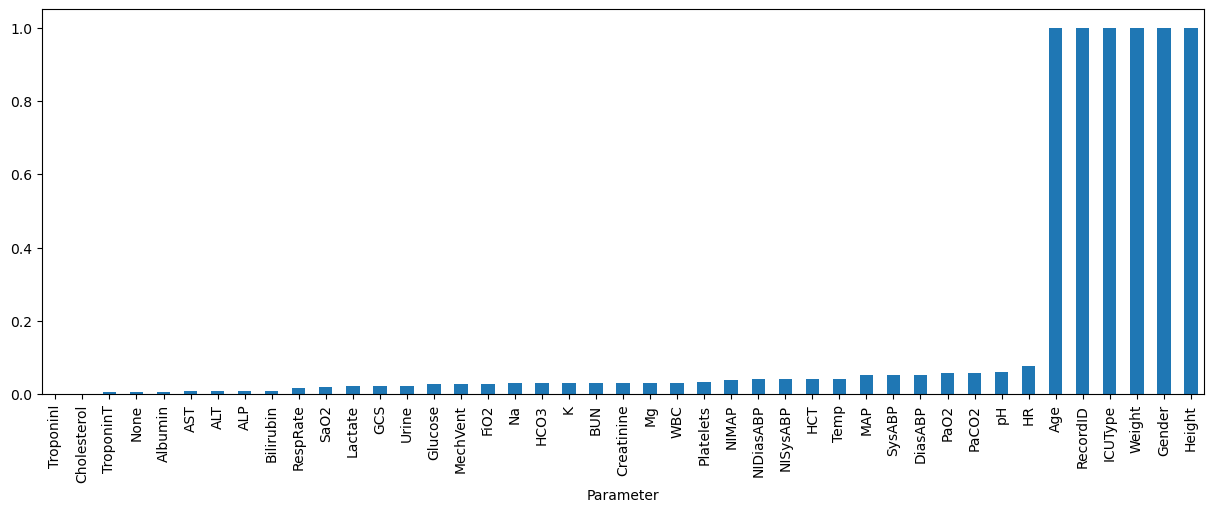

In [15]:
# number available measurements per variable per patient
na_groups = ["PatientID", "Time"]
data.groupby(na_groups[:]).count().mean().sort_values()
data.groupby(na_groups[:]).count().mean().sort_values().plot(kind="bar", figsize=(15, 5))
# print(dynamic_vars)

Number of patients with more than 1 observation in more than 5 variables: 510
Number of variables with more than 1 observation in more than 100 patients: 28


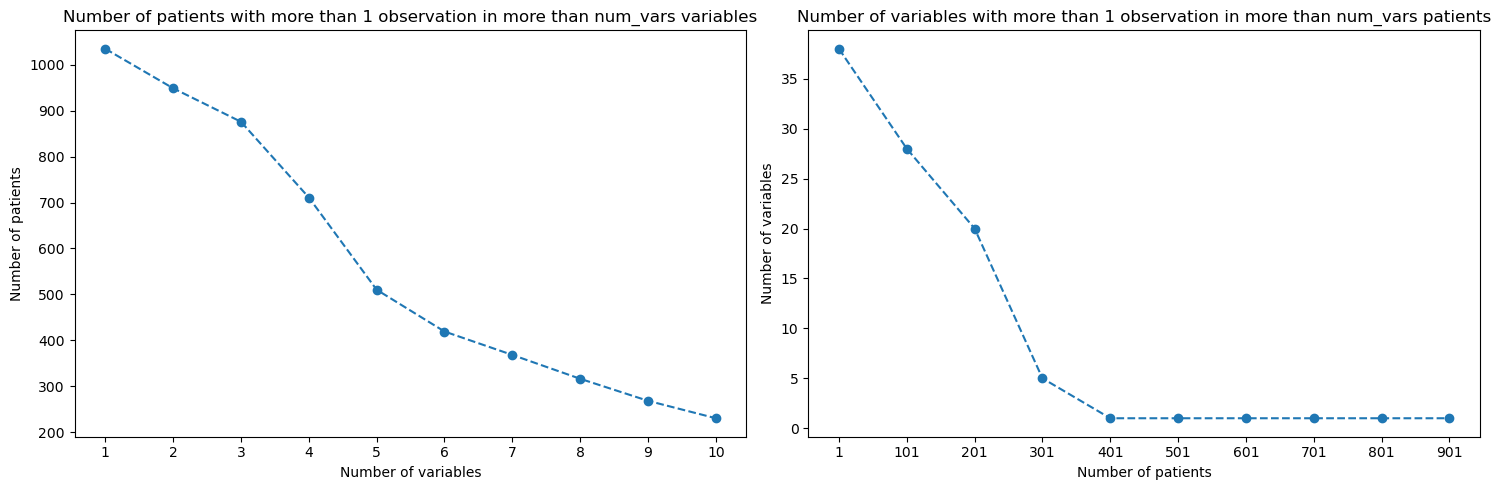

In [16]:

patients_var_counts = data.groupby("PatientID").count()[dynamic_vars]

# list patients that have more than 1 observation in more than num_vars variables
num_vars_patients = 5
num_vars_columns = 100

patient_count_greater_numvars = patients_var_counts[(patients_var_counts > 1).sum(axis=1) > num_vars_patients].index.tolist()
# variable_count_greater_numvars = patients_var_counts[((patients_var_counts > 1).sum(axis=0) > num_vars_columns).index.tolist()]
variable_count_greater_numvars = patients_var_counts.columns[((patients_var_counts > 1).sum(axis=0) > num_vars_columns)]
print("Number of patients with more than 1 observation in more than {} variables: {}".format(num_vars_patients, len(patient_count_greater_numvars)))
print("Number of variables with more than 1 observation in more than {} patients: {}".format(num_vars_columns, variable_count_greater_numvars.shape[0]))

loop_num_vars_patients = 10
loop_num_vars_columns = 1000
# plot the data by looping over num_vars_patients
patient_count_greater_numvars_list = [patients_var_counts[(patients_var_counts > 1).sum(axis=1) > num_vars_patients].index.tolist() for num_vars_patients in np.arange(1, loop_num_vars_patients+1)]
variable_count_greater_numvars_list = [patients_var_counts.columns[((patients_var_counts > 1).sum(axis=0) > num_vars_columns)].tolist() for num_vars_columns in np.arange(1, loop_num_vars_columns+1, 100)]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.arange(1, loop_num_vars_patients+1), [len(x) for x in patient_count_greater_numvars_list], "o--")
ax[0].set_xlabel("Number of variables")
ax[0].set_ylabel("Number of patients")
ax[0].set_title("Number of patients with more than 1 observation in more than num_vars variables")
ax[0].set_xticks(np.arange(1, loop_num_vars_patients+1))
ax[1].plot(np.arange(1, loop_num_vars_columns+1, 100), [len(x) for x in variable_count_greater_numvars_list], "o--")
ax[1].set_xlabel("Number of patients")
ax[1].set_ylabel("Number of variables")
ax[1].set_title("Number of variables with more than 1 observation in more than num_vars patients")
ax[1].set_xticks(np.arange(1, loop_num_vars_columns+1, 100))
plt.tight_layout()
plt.show()

In [17]:
data[["Time", "PatientID", "Glucose"]].head(5)

data.Time.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48],
      dtype=int64)

### Univariate analysis

In [18]:
# Dropdowns
column_selector = widgets.Dropdown(
    options=data.columns.tolist(),
    description='Feature:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

groupby_selector = widgets.Dropdown(
    options=['None', 'AgeGroup', 'Gender', 'ICUType', 'WeightGroup'],
    value='None',
    description='Color by:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

output = widgets.Output()

def display_histogram(column, groupby):
    output.clear_output(wait=True)
    with output:
        col_data = data[column].dropna()
        plt.figure(figsize=(8, 5))
        
        if np.issubdtype(col_data.dtype, np.number):
            # Summary stats
            stats = {
                'Mean': np.mean(col_data),
                'Median': np.median(col_data),
                'Std': np.std(col_data),
                'Min': np.min(col_data),
                'Max': np.max(col_data),
                'IQR': np.percentile(col_data, 75) - np.percentile(col_data, 25)
            }
            title = ', '.join([f'{k}: {v:.2f}' for k, v in stats.items()])
            
            if groupby != 'None' and groupby in data.columns:
                for group_val in data[groupby].dropna().unique():
                    subset = data[data[groupby] == group_val][column].dropna()
                    plt.hist(subset, bins=20, alpha=0.5, label=str(group_val), edgecolor='black')
                plt.legend()
            else:
                plt.hist(col_data, bins=20, color='skyblue', edgecolor='black', alpha=0.75)

            plt.title(f'{column} Histogram\n{title}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
        
        else:
            # For categorical: bar plot
            if groupby != 'None' and groupby in data.columns:
                cross_tab = pd.crosstab(data[column], data[groupby])
                cross_tab.plot(kind='bar', stacked=True, edgecolor='black', alpha=0.8, figsize=(8, 5))
                plt.title(f'{column} Count by {groupby}')
                plt.xlabel(column)
                plt.ylabel('Count')
                plt.tight_layout()
                plt.show()
                return
            else:
                value_counts = col_data.value_counts()
                value_counts.plot(kind='bar', color='lightcoral', edgecolor='black', alpha=0.8)
                plt.title(f'{column} Value Counts\nMode: {col_data.mode()[0]}, Unique: {col_data.nunique()}')
                plt.xlabel(column)
                plt.ylabel('Count')

        plt.tight_layout()
        plt.show()

# Link widgets to function
widgets.interact(display_histogram, column=column_selector, groupby=groupby_selector)
display(output)


interactive(children=(Dropdown(description='Feature:', layout=Layout(width='50%'), options=('Time', 'BUN', 'Cr…

Output()

In [19]:
## Dynamic Variable Analysis
# TODO add mask to explore patents with actual observations

# Dropdowns
value_selector = widgets.Dropdown(
    options=[col for col in data.columns if col not in ['Time', 'PatientID']],
    description='Y-Axis Variable:',
    layout=widgets.Layout(width='50%')
)

patient_selector = widgets.SelectMultiple(
    options=sorted(data['PatientID'].unique()),
    # value=('P001',),
    description='Patients:',
    layout=widgets.Layout(width='50%', height='120px')
)

output = widgets.Output()

# Plotting function
def plot_time_series(y_col, PatientIDs):
    output.clear_output(wait=True)
    with output:
        plt.figure(figsize=(10, 5))
        for pid in PatientIDs:
            data_pid = data[data['PatientID'] == pid]
            plt.plot(data_pid['Time'], data_pid[y_col], label=f'Patient {pid}')
        plt.title(f'{y_col} over Time')
        plt.xlabel('Time')
        plt.ylabel(y_col)
        plt.legend()
        plt.tight_layout()
        plt.grid(True)
        plt.show()

# Link interaction
widgets.interact(plot_time_series, y_col=value_selector, PatientIDs=patient_selector)
display(output)


interactive(children=(Dropdown(description='Y-Axis Variable:', layout=Layout(width='50%'), options=('BUN', 'Cr…

Output()